In [1]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import pickle

Number of Cars: 8792
Number of Non-Cars: 8968
Reading of Vehicle Images: 8792
Reading of Non Vehicle Images: 8968


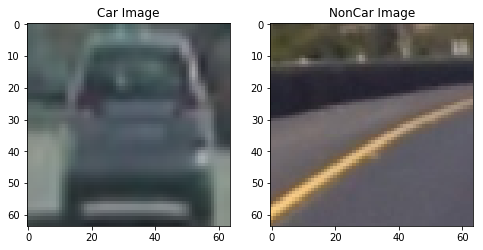

In [2]:
# READ TRAINING DATASET

cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

print('Number of Cars:', len(cars))
print('Number of Non-Cars:', len(notcars))

# read images and append to list
car_images=[]
for image_path in cars:
    car_images.append(mpimg.imread(image_path))

print('Reading of Vehicle Images:', len(car_images))

noncar_images=[]
for image_path in notcars:
    noncar_images.append(mpimg.imread(image_path))

print("Reading of Non Vehicle Images:", len(noncar_images))

fig = plt.figure(figsize=(8, 16))
plt.subplot(121)
plt.imshow(car_images[5])
plt.title('Car Image')
plt.subplot(122)
plt.imshow(noncar_images[5])
plt.title('NonCar Image')

In [3]:
# HELPER FUNCTIONS

def convert_image(image, color_space='RGB'):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'Gray':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)            
    else: feature_image = np.copy(image) 
        
    return feature_image

In [4]:
# HELPER FUNCTIONS

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  block_norm= 'L2-Hys',
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       block_norm= 'L2-Hys',
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [5]:
# USE ipywidgets TO FIND SUITABLE HOG PARAMETERS

def extract_widget_features(image, color_space='RGB', visualize=False, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    feature_image = convert_image(image,color_space)
    image_shape = feature_image.shape
    hog_features, hog_images = [], []
    #print('feature_image:', len(image_shape))
    if len(image_shape) == 2:
        hog_features, hog_images = get_hog_features(feature_image, orient,
                    pix_per_cell, cell_per_block, vis=visualize, feature_vec=True)        
    else:
        for channel in range(len(image_shape)):
            hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], orient, 
                    pix_per_cell, cell_per_block, vis=visualize, feature_vec=True)
            hog_features.append(hog_feature)
            hog_images.append(hog_image)
    return hog_features, hog_images

def hog_feature_test(image_path, color_s, ori=5, ppc=8, cpb=2, vis=False):
    image = mpimg.imread(image_path)
    hog_features, hog_images = extract_widget_features(image, color_space=color_s, orient=ori, 
                        pix_per_cell=ppc, cell_per_block=cpb, visualize=vis)
    #print('hog_features:', len(hog_features))
    if len(hog_features) == 3:
        fig = plt.figure(figsize=(20, 40))
        plt.subplot(141)
        plt.imshow(image, cmap='gray')
        if hog_images[0] is not None:
            print('feature_vector:', len(hog_features[0]))
            print('hog image:', len(hog_images[0].ravel()))
            plt.title('Example Car Image')
            plt.subplot(142)
            plt.imshow(hog_images[0], cmap='gray')
            plt.title('Channel 1 Visualization')    
            plt.subplot(143)
            plt.imshow(hog_images[1], cmap='gray')
            plt.title('Channel 2 Visualization')    
            plt.subplot(144)
            plt.imshow(hog_images[2], cmap='gray')
            plt.title('Channel 3 Visualization')    
    else:
        print('feature_vector:', len(hog_features))
        print('hog image:', len(hog_images.ravel()))
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_images, cmap='gray')
        plt.title('HOG Visualization')    
        
#image = extract_features('./test_images/test1.jpg')    
interact(hog_feature_test, image_path='./train_images/1.png',
        color_s={'RGB':'RGB', 'Gray':'Gray', 'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'},
        ori=widgets.IntSlider(min=2,max=12,step=1,value=8, continuous_update=False, description="Orientation:"),
        ppc=widgets.IntSlider(min=4,max=24,step=4,value=8, continuous_update=False, description="pix_per_cell:"),
        cpb=widgets.IntSlider(min=2,max=8,step=2,value=2, continuous_update=False, description="cell_per_block:"),
        vis=widgets.Checkbox(value=True,description='Is Visualize',disabled=False));

interactive(children=(Text(value='./train_images/1.png', description='image_path'), Dropdown(description='colo…

In [6]:
# EXTRACT FEATURES FOR TRAINING

def extract_spatial_hist_feature(images, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    features = []
    # Iterate through the list of images
    for image in images:
        feature_image = convert_image(image, color_space)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(images, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    
    for image in images:
        feature_image = convert_image(image, color_space)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    return features

In [7]:
# THE TRAINING PIPELINE

def train_pipeline(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, y_train = shuffle(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=rand_state)     

    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_valid = X_scaler.transform(X_valid)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_valid, y_valid), 4))
    return svc, X_scaler

In [8]:
# TRAIN SPATIAL & HISTOGRAM FEATURE

def color_classify(car_images, noncar_images, cspace='RGB', spatial=16, histbin=32):
    print('Using cspace:', cspace, 'with spatial binning of:',spatial, 'and', histbin,'histogram bins')
    t=time.time()
    car_features = extract_spatial_hist_feature(car_images, color_space=cspace, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    notcar_features = extract_spatial_hist_feature(noncar_images, color_space=cspace, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract color feature...')    
    train_pipeline(car_features, notcar_features)

In [9]:
# TRAIN HOG FEATURE

def hog_classify(car_images, notcar_images, colorspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    print('Using colorspace:', colorspace, 'with these details:',orient, pix_per_cell, cell_per_block,hog_channel)
    t=time.time()
    car_features = extract_hog_features(car_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_hog_features(notcar_images, color_space=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract hog feature')       
    train_pipeline(car_features, notcar_features)

In [ ]:
color_classify(car_images, noncar_images, spatial=16, cspace='YUV')

In [ ]:
hog_classify(car_images, noncar_images, colorspace='YUV', hog_channel='ALL')

In [10]:
# EXTRACT ALL FEATURES FROM A SIGNLE IMAGE

def extract_all_features_single_image(image, color_space='RGB', spatial_size=16,
                        hist_bins=32, hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

    feature_image = convert_image(image, color_space)
    image_features = []

    #Spatial feature
    spatial_features = bin_spatial(feature_image, size=(spatial_size,spatial_size))
    image_features.append(spatial_features)

    #Histogram feature
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    image_features.append(hist_features)

    #Hog feature
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    image_features.append(hog_features)

    # Return list of feature vectors
    return np.concatenate(image_features)

In [11]:
# EXTRACT ALL FEATURES FROM A LIST OF IMAGES
# USE THIS FOR TRAINING
def extract_all_features_all_images(images, color_space='RGB', spatial_size=16,
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    print('Using colorspace:', color_space, 'with these details:', spatial_size, hist_bins, orient, pix_per_cell, cell_per_block,hog_channel)
    for image in images:
        image_features = extract_all_features_single_image(image, color_space, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel)
        features.append(image_features)
    # Return list of feature vectors
    return features

In [12]:
# CLASSIFIER WHICH COMBINES ALL FEATURES

def combined_classify(car_images, notcar_images, colorspace='RGB', spatial_size=16,
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    t=time.time()
    car_features = extract_all_features_all_images(car_images, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_all_features_all_images(notcar_images, color_space=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract all features:', colorspace, orient, pix_per_cell, cell_per_block, hog_channel)       
    return train_pipeline(car_features, notcar_features)

In [ ]:
# TRAINING THE FINAL CLASSIFIER

classifier, X_scaler = combined_classify(car_images, noncar_images, colorspace='YUV', hog_channel='ALL')

In [13]:
# FINAL HYPERPARAMETERS

color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = 16
hist_bins = 32
y_start_stop = [400, 650] # Min and max in y to search in slide_window()
x_start_stop = [250, 1280] # Min and max in x to search in slide_window()

In [ ]:
with open('classifier_1632_YUVAll.p', 'wb') as handle:
    pickle.dump(classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('scaler_1632_YUVAll.p', 'wb') as handle:
    pickle.dump(X_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [14]:
# USE PICKLE TO SAVE TIME

classifier = pickle.load( open("classifier_1632_YUVAll.p", "rb" ) ) #Load svc
X_scaler = pickle.load( open("scaler_1632_YUVAll.p", "rb" ) ) #Load X_scaler

In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [16]:
def detect_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              hog_channel, color_space):

    on_windows = []
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_image(img_tosearch, color_space)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above, hold the number of hog cells
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step: there are 8 cells, and move 2 cells per step, 75% overlap
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            #print('subimg shape:', subimg.shape, spatial_size)
            spatial_features = bin_spatial(subimg,  size=(spatial_size,spatial_size))

            hist_features = color_hist(subimg, nbins=hist_bins)

            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(X)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                on_windows.append(((xbox_left + xstart, ytop_draw+ystart),(xbox_left+ xstart + win_draw,ytop_draw+win_draw+ystart)))

    return on_windows

total windows: 341


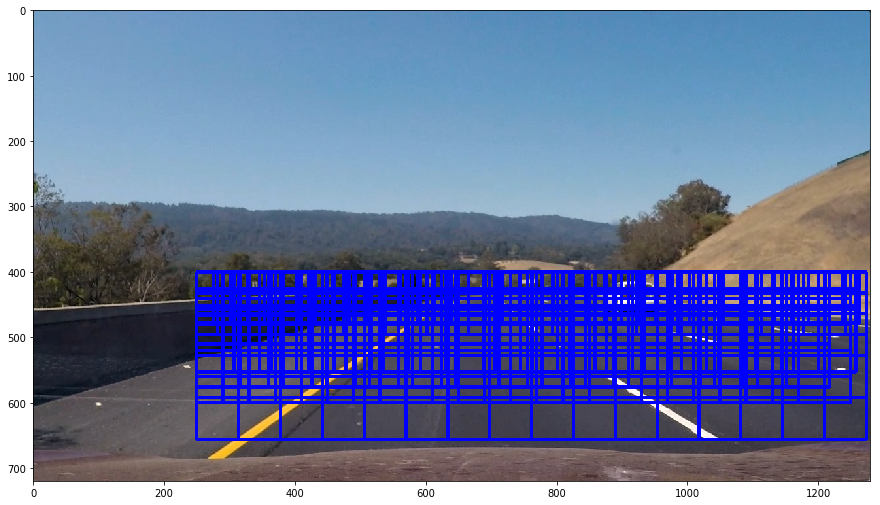

In [17]:
# FIND ALL WINDOWS THAT WILL BE USED TO DETECT VEHICLE

image = mpimg.imread('./test_images/test3.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255

windows0 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,500], 
                    xy_window=(52, 52), xy_overlap=(0.5, 0.5))
windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,600], 
                    xy_window=(80, 80), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.4, 0.4))
windows4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,600], 
                    xy_window=(110, 110), xy_overlap=(0.4, 0.4))
windows5 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[400,660], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

windows= windows0 +  windows1  + windows2 + windows3 + windows4 + windows5
print('total windows:',len(windows))
window_img = draw_boxes(draw_image, windows, thick=3)
fig = plt.figure(figsize=(15,30))
plt.imshow(window_img)

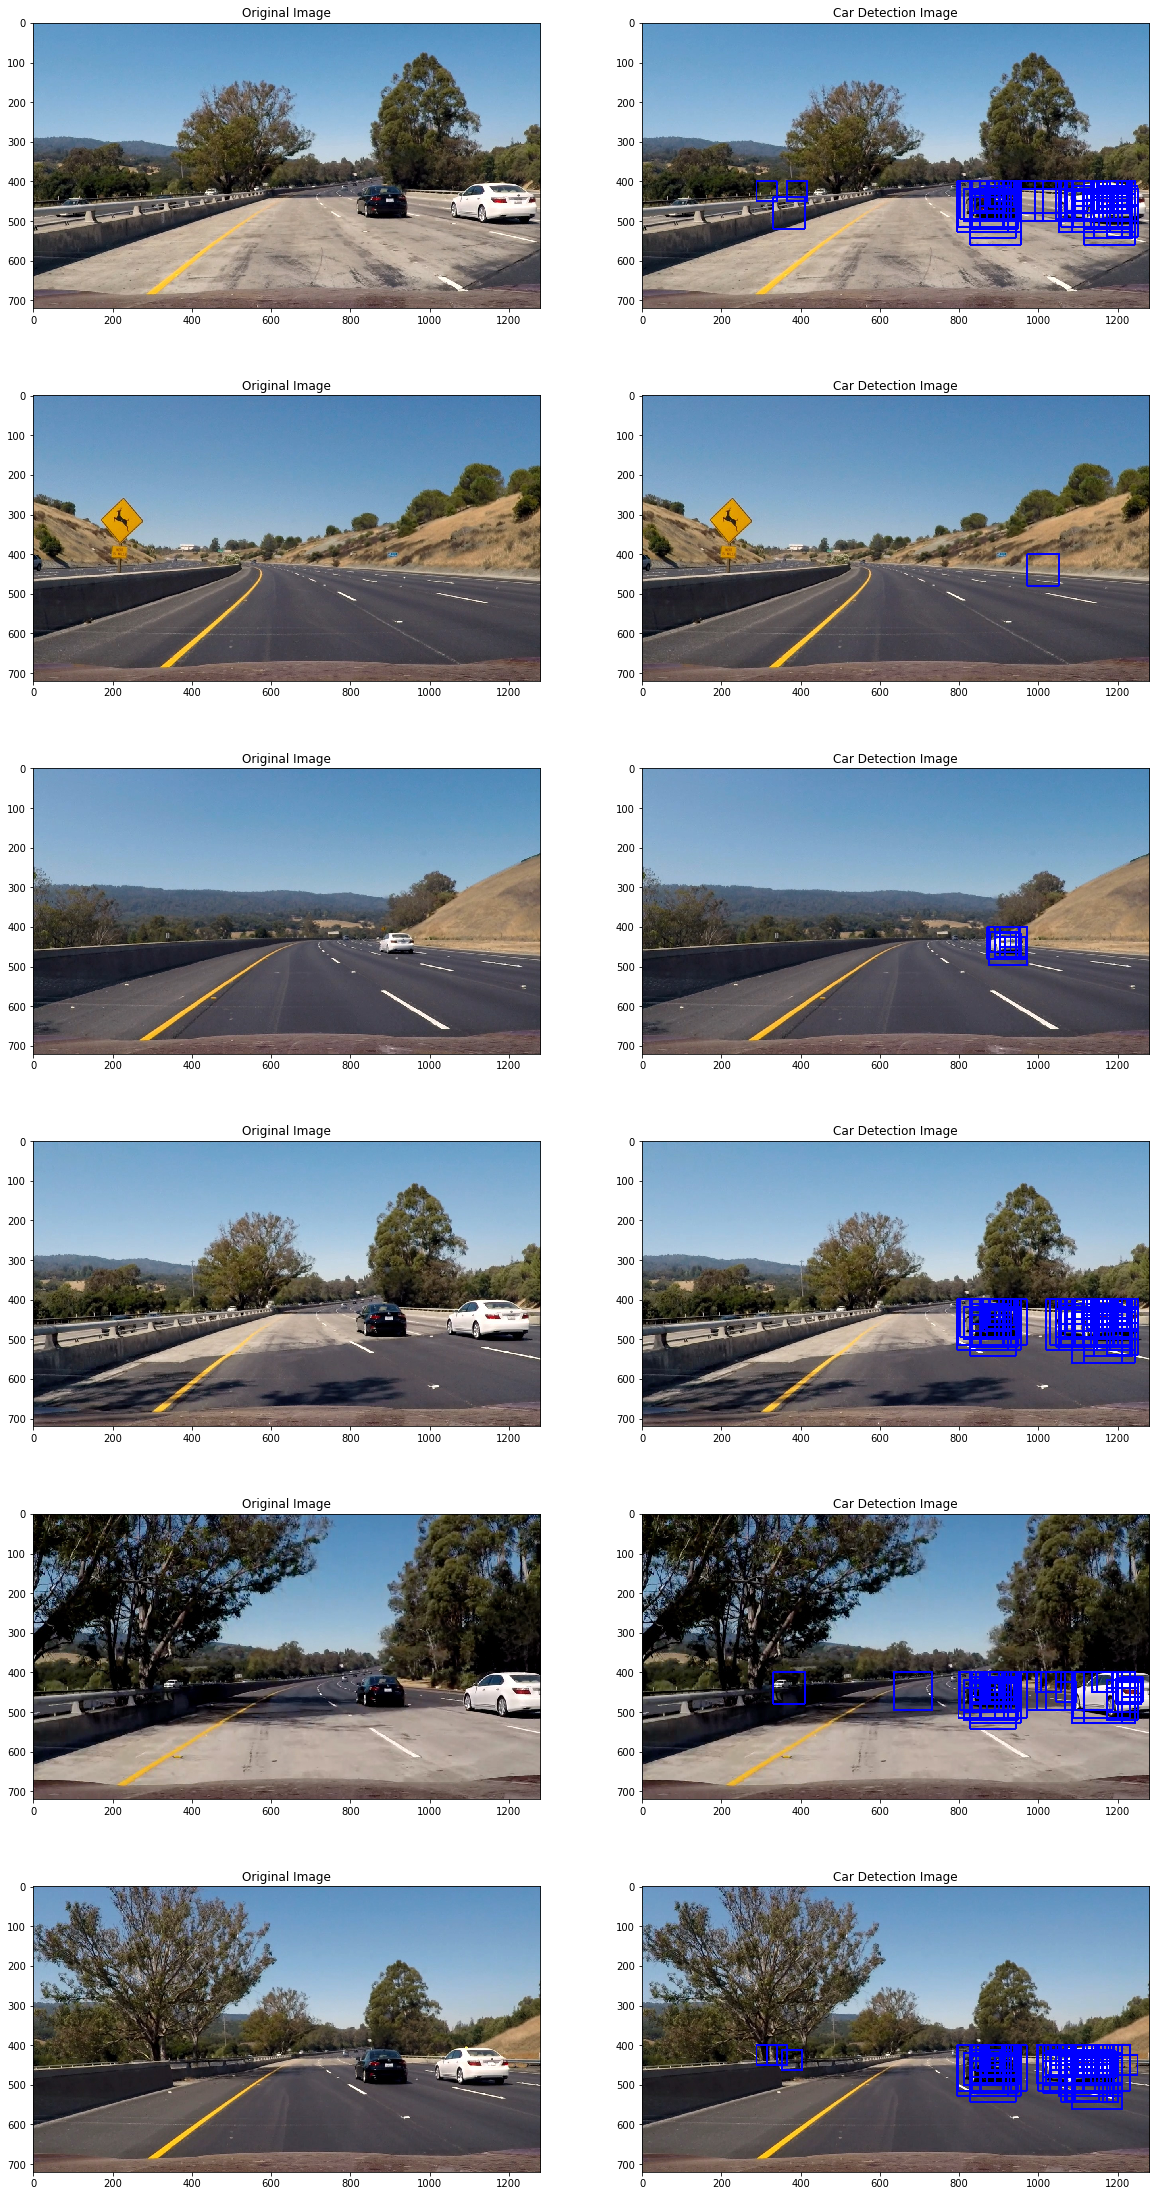

In [18]:
# RUN THE PIPELINE THROUGH TEST_IMAGES

test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(len(test_images),2, figsize=(20,40))

for index,image in enumerate(test_images):
    image = mpimg.imread(image)
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255

    scales = [[0.8, 400, 500], [1, 400, 500], [1.25, 400, 600], [1.5, 400, 600], [1.8, 400, 600], [2, 400, 660]]
    hot_windows = []

    for scale in scales:
        bboxes = detect_cars(image, scale[1], scale[2], 250, 1280, scale[0], X_scaler = X_scaler, svc = classifier, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        if len(bboxes) > 0:
            for box in bboxes:
                hot_windows.append(box)

    window_img = draw_boxes(draw_image, hot_windows, thick=3)
    
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(window_img)
    axes[index,1].set_title("Car Detection Image")

In [19]:
# HEATMAP & THRESHOLD FUNCTIONS

from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0,0,255)):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
    # Return the image
    return img

def apply_heatmap(image,box_list,threshold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

In [20]:
# THE FINAL CAR DETECTION PIPELINE

heatmap_threshold = 5

def car_search_pipeline(image, heatmap_visualize = True):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    scales = [[0.8, 400, 500], [1, 400, 500], [1.25, 400, 600], [1.5, 400, 600], [1.8, 400, 600], [2, 400, 660]]
    hot_windows = []
    
    for scale in scales:
        bboxes = detect_cars(image, scale[1], scale[2], 250, 1280, scale[0], X_scaler = X_scaler, svc = classifier, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        if len(bboxes) > 0:
            for box in bboxes:
                hot_windows.append(box)

    draw_img, heatmap = apply_heatmap(draw_image,hot_windows,heatmap_threshold)
    
    if heatmap_visualize:
        return draw_img, heatmap
    else:
        return draw_img

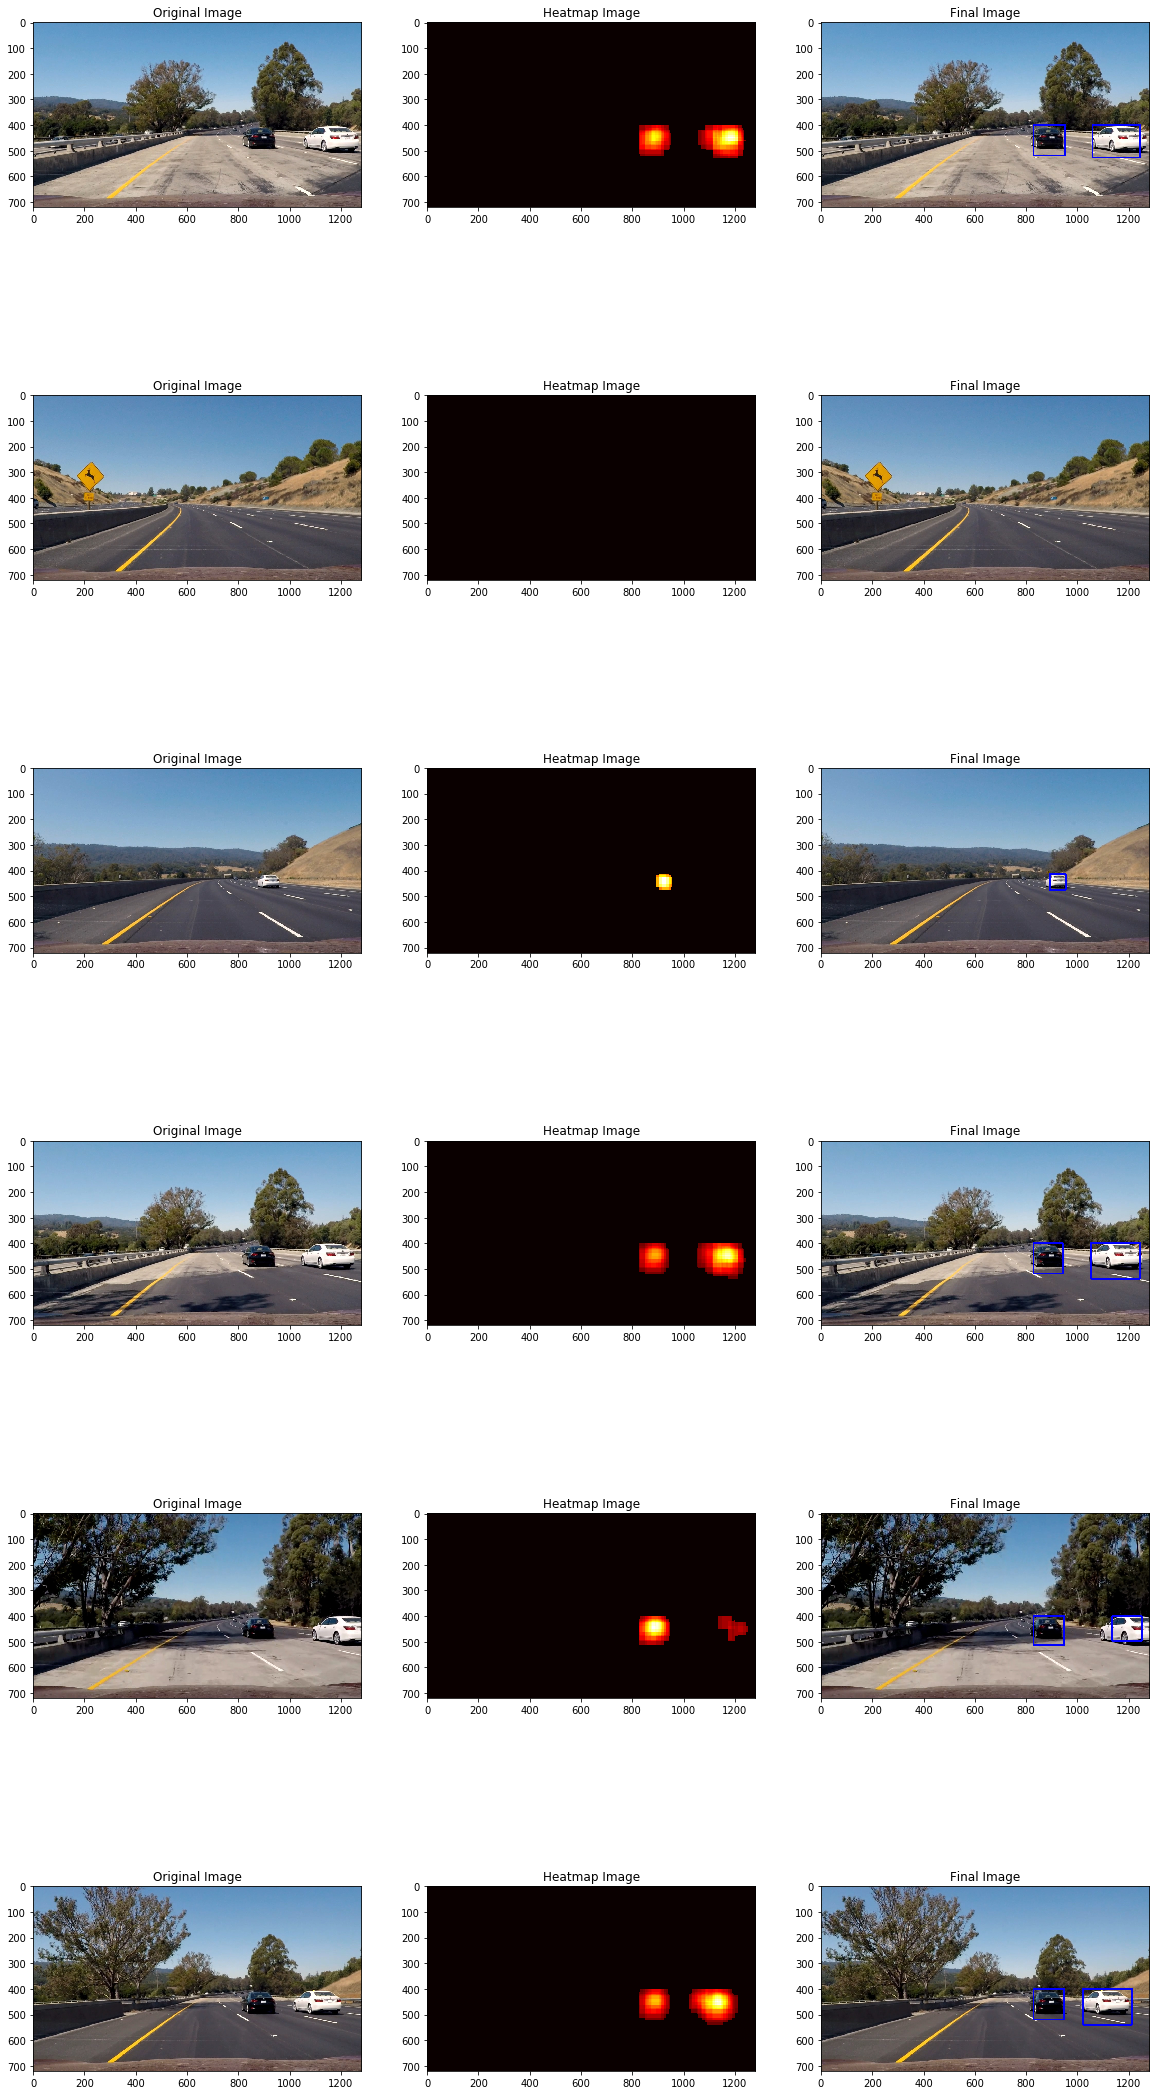

In [21]:
# RUN THE FINAL PIPELINE THROUGH TEST_IMAGES

test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(len(test_images),3, figsize=(20,40))
for index,image in enumerate(test_images):
    image = mpimg.imread(image)
    #draw_image = np.copy(image)

    finalPic,heatmap = car_search_pipeline(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='hot')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")

In [ ]:
# VIDEO OUTPUT

import moviepy
from moviepy.editor import VideoFileClip

print(color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
video_output1 = 'test.mp4'
video_input1 = VideoFileClip('./project_video.mp4')
processed_video = video_input1.fl_image(lambda image: car_search_pipeline(image,heatmap_visualize=False))
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()